# Gads Binding Cooperativity Parameter Estimation Program
## Developed by Dr. Frushicheva @ MIT

## Import Python Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint, quad
from scipy import optimize
import matplotlib.pyplot as plt 
%matplotlib inline

## Import and Plot Experimental Data

In [2]:
# WT exp. data in uM
WT_raw_exp_y=np.array([0.294207761,0.26337707,0.23638426,0.214669316,0.179110633])
sd_WT=np.array([0.000117522,0.00033228,0.000167249,0.000169248,6.7524E-05])

# F92D exp. data in uM
F2D_raw_exp_y = np.array([0.271768565,0.213041181,0.184558209,0.172836008,0.15602546])
sd_F2D=np.array([0.000172372,0.000113375,0.000101194,0.000195189,0.000130786])

# 1pY-LAT exp. concentration in uM 
L0_exp = np.array([0,5,10,15,20])

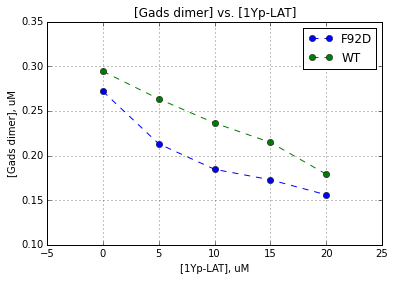

In [3]:
# Plot the Experimental Data
plt.figure(1)
plt.errorbar(L0_exp,F2D_raw_exp_y,yerr=sd_F2D,fmt='--o') # plot for F92D mutant
plt.errorbar(L0_exp,WT_raw_exp_y,yerr=sd_WT,fmt='--o') # plot for WT
plt.title('[Gads dimer] vs. [1Yp-LAT]')
plt.xlabel('[1Yp-LAT], uM')
plt.ylabel('[Gads dimer], uM')
plt.legend(['F92D','WT'])
plt.axis([-5,25,0.10,0.35])
plt.grid(True)
plt.show()

In [4]:
# IMPORTANT: Set fitting till 20 uM
cut = 5 # 5 # equals 5 for fitting till 20 uM

# IMPORTANT: Select the Data Set Here
raw_exp_y = F2D_raw_exp_y # WT_raw_exp_y or F2D_raw_exp_y 
raw_exp_y = raw_exp_y[0:cut]

# Exp. data converted from uM to computational units of number of molecules
exp_y=raw_exp_y*50/(0.7*0.5)

## Parameters Used in Calculations in Computer Units

In [5]:
# Concentrations
G=35 # Gads = 0.7 uM
L=250 # 2pY-LAT = 5 uM
L0=L0_exp*50 # convert 1pY-LAT concentration to computer units
L0=L0[0:cut]

# Monomeric Rate Constants
# for WT: kon = 4.52 1/(uM*s) = 0.09 1/(molec*s)
# for F92D: kon = 1.70 1/(uM*s) = 0.03 1/(molec*s)
# koff = 0.8 1/s
kon = 0.03 # IMPORTANT: Select the Corresponding System Here !!! 
koff = 0.8

kon_m = kon
koff_m = koff

kon_m2 = kon
koff_m2 = koff

kon_d = kon
koff_d = koff

k1 = kon_m # kon of 2pY-LAT: G + L -> L01
k2 = kon_m # kon of 2pY-LAT: G + L -> L10
k3 = koff_m # koff of 2pY-LAT: G + L <- L01
k4 = koff_m # koff of 2pY-LAT: G + L <- L10

k5 = kon # kon of 1pY-LAT: G + L0 -> L0_10
k6 = koff # koff of 1pY-LAT: G + L0 <- L0_10

# Unknown Rate Constants 
# 1) Dimer Formation from Gads-bound LAT Monomers
k7 = kon_m2 # kon of 2pY-LAT: G + L01 -> L11
k8 = kon_m2 # kon of 2pY-LAT: G + L10 -> L11
k9 = koff_m2 # koff of 2pY-LAT: G + L01 <- L11
k10 = koff_m2 # koff_m2 # koff of 2pY-LAT: G + L10 <- L11

# 2) Dimer Formation Overall
k11 = kon_d # kon of 2G + L -> L11
k12 = koff_d # koff of 2G + L <- L11 

# Set up Time for Calculations
t_graph = np.arange(0, 600, 0.1)

## Systems of ODEs

In [6]:
def calc(p,t,param):
    R0,R1,R2,R3,R4,R5,R6 = p
    # R0 = G, R1 = L, R2 = L10, R3 = L11, R4 = L01, R5 = L0, R6 = L0_10
    k9,k10,k12 = param # full model
    #k11,k12 = param # simplified model
              
    R00=-k1*R0*R1+k3*R2-k7*R0*R2+k9*R3-k2*R0*R1+k4*R4-k8*R0*R4+k10*R3-k5*R0*R5+k6*R6-k11*R0*R0*R1+k12*R3    
    R10=-k1*R0*R1+k3*R2-k2*R0*R1+k4*R4-k11*R0*R0*R1+k12*R3            
    R20=k1*R0*R1-k3*R2-k7*R0*R2+k9*R3           
    R30=k7*R0*R2-k9*R3+k8*R0*R4-k10*R3+k11*R0*R0*R1-k12*R3
    R40=k2*R0*R1-k4*R4-k8*R0*R4+k10*R3   
    R50=-k5*R0*R5+k6*R6  
    R60=k5*R0*R5-k6*R6  
    
    return [R00, R10, R20, R30, R40, R50, R60]

## Simulation

In [7]:
P=[] # initialize array for RSS = COST function
X=[]

def func(param,i):
    p0 = [G,L,0,0,0,L0[i],0]
    soln=odeint(calc,p0,t_graph,args=(param,),mxstep=10000)
    R3 = soln[:,3]
    diff = R3[-1]-exp_y[i]
    return diff

def obj_fun(x):
    return np.sum((func(x,j)**2 for j in range(0,len(L0))),axis=0)

# specify initial condition 
num=1e-4 # for a full model: WT and F92D num = 1e-4
         # for a simplified model: WT and F92D num = 1e-6
    
x0=[num,num,num] # intial parameter guess
bounds=[(num,None)]*3 # boundaries for parameter optimization

x,f,d = optimize.fmin_l_bfgs_b(obj_fun, x0=x0, approx_grad=True,bounds=bounds)

k9,k10,k12 = x # for a full model
print k9,k10,k12 

#k11,k12 = x # for simplified model
#print k11,k12

print f
print d

0.00199529511967 0.00199629181168 0.0445917853694
8.88481096268
{'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([ -4.65927918,  17.25476846,  61.88377721]), 'nit': 15, 'funcalls': 172}


## Results: Fitting the Experimental Data Using the Optimized Parameter

In [8]:
param = [k9,k10,k12] # optimized parameters
#param = [k11,k12]
result=[] # initialize the result array
for i in range(0,len(L0)):
    p0 = [G,L,0,0,0,L0[i],0]
    soln=odeint(calc,p0,t_graph,args=(param,))
    R3 = soln[:,3]
    result.append(R3[-1])

In [9]:
# Compare the experimenal and calculated results using the oprimized parameter
result=np.array(result)
print "Calculated Gads dimer in uM"
print result*0.7*0.5/50 # convert the results from computer to experimental units
print "Experimental Gads dimer in uM"
print raw_exp_y

# Calculate R^2
from sklearn.metrics import r2_score
y_true = raw_exp_y
y_pred = result*0.7*0.5/50

print "R^2 value:"
print 'R^2 =', round(r2_score(y_true, y_pred),2)

Calculated Gads dimer in uM
[ 0.26080334  0.22482422  0.19477616  0.16953087  0.14821846]
Experimental Gads dimer in uM
[ 0.27176857  0.21304118  0.18455821  0.17283601  0.15602546]
R^2 value:
R^2 = 0.95


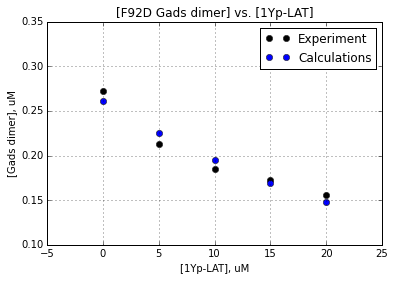

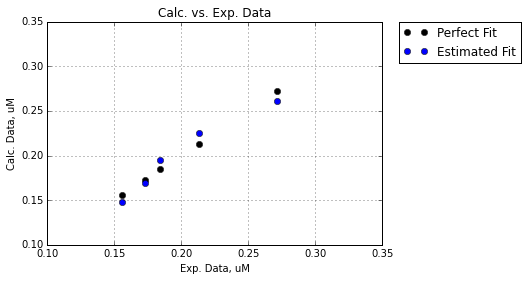

In [10]:
# Plot the calculated and experimental results
plt.figure(1)
plt.plot(L0/50,raw_exp_y,'ko')
plt.plot(L0/50,result*0.7*0.5/50,'bo')
plt.title('[F92D Gads dimer] vs. [1Yp-LAT]')
plt.xlabel('[1Yp-LAT], uM')
plt.ylabel('[Gads dimer], uM')
plt.legend(['Experiment','Calculations'])
plt.axis([-5,25,0.10,0.35])
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(raw_exp_y,raw_exp_y,'ko',raw_exp_y,result*0.7*0.5/50,'bo')
plt.title('Calc. vs. Exp. Data')
plt.xlabel('Exp. Data, uM')
plt.ylabel('Calc. Data, uM')
plt.legend(['Perfect Fit','Estimated Fit'],bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.axis([0.10,0.35,0.10,0.35])
plt.grid(True)
plt.show()

## Calculations of Cooperativity and Binding Constants

In [11]:
print 'k11 =', round(k11,4)
# convert kon rates from computer to exp. units
k11 = k11 * 2.31 * 1e+3 * 1e+12 # in 1/(s*M**2)
k7 = k7 * 50 * 1e+6 # in 1/(M*s) 
k8 = k8 * 50 * 1e+6 # in 1/(M*s)

# Experimental Values for KA1 for WT and F92D
WT_KA1 = 5.65 * 1e+6 # in 1/M
F2D_KA1 = 2.12 * 1e+6 # in 1/M

# IMPORTANT: Select the Corresponding System Here 
KA1= F2D_KA1 # WT_KA1 or F2D_KA1

# Calculated Constants
beta2 = k11 / k12
KA2 = k7 / k9 # from optimized k9
#KA2 = beta2 / KA1 # from optimized k12
KD2 = 1 / KA2
rho= KA2 / KA1 # from optimized k9
#rho = beta2 / (KA1)**2 # from optimized k12

print "Calc. Const.\t Values\t\tUnits \t\tConv. Values\tConv. Units"
np.set_printoptions(precision=2)
print "beta2\t\t %.3g \t1/M**2 \t\t%.3g \t1/uM**2" % (beta2,beta2*1e-12)
print "1/beta2\t\t %.3g \tM**2 \t\t%.3g \t\tnM**2" % (1/beta2,1e+18/beta2)
print "KA2 \t\t %.3g \t1/M \t\t%.3g \t1/uM" % (KA2,KA2*1e-6)
print "KD2 \t\t %.3g \tM \t\t%.3g \t\tnM" % (KD2,KD2*1e+9)
print "rho\t\t %.3g" % rho

k11 = 0.03
Calc. Const.	 Values		Units 		Conv. Values	Conv. Units
beta2		 1.55e+15 	1/M**2 		1.55e+03 	1/uM**2
1/beta2		 6.43e-16 	M**2 		643 		nM**2
KA2 		 7.52e+08 	1/M 		752 	1/uM
KD2 		 1.33e-09 	M 		1.33 		nM
rho		 355


In [12]:
print 'k9 =', round(k9,3)
print 'k10 =', round(k10,3)
print 'k11 =', round(k11,3)
print 'k12 =', round(k12,3)

k9 = 0.002
k10 = 0.002
k11 = 6.93e+13
k12 = 0.045
